# Vectorizing t-test and F-tests for unequal variances

Almost all modern data science tasks begin with exploratory data analysis ([EDA](https://en.wikipedia.org/wiki/Exploratory_data_analysis)) phase. Visualizing summary statistics and testing for associations forms the basis of hypothesis generation and subsequent exploration and modeling. Applied statisticians need to be careful not to over-interpret the results of EDA since the p-values generated during this phase do not correspond to their formal definition when used in a highly proscribed scenario. Speed is often an asset during EDA. I recently encountered the problem of needing to assess thousands of AUROC statistics (discussed in the past [here](http://www.erikdrysdale.com/auc_CI/) and [here](http://www.erikdrysdale.com/auc_max/)), and found the bootstrapping procedure to be too slow for high-throughput assessment. By relying on the asymptotic normality of the AUROC statistic (which is an instance of the [Mann-Whitney U-test](https://en.wikipedia.org/wiki/Mann–Whitney_U_test)), rapid inference could be performed because an analytic solution was available. However, I needed to develop code that could properly address the bottlenecks of my analysis:

1. Use only the moments of the data (mean, variance, and sample size)
2. (Possibly) accounting for unequal variances
3. Vectorizing all functions

In the rest of the post, I'll provide simple functions in `python` that will vectorize the [Student's t-test](https://en.wikipedia.org/wiki/Student%27s_t-test) and the [F-test](https://en.wikipedia.org/wiki/F-test) for the multiple comparisons problem. Each of these functions will rely on only the first two moments of the data distribution (plus the sample size). Using only the sufficient statistics of the data helps to reduce the memory overhead that other functions normally have. Means and variances can be computed quickly using methods that are already part of `pandas` and `numpy` classes. The functions in this post will also be able to account for unequal variances, which to best of my knowledge, is not available in existing `python` packages for the F-test.

## (1) Student's t-test for equal means

Suppose there are two normally distributed samples: $x = (x_1, \dots, x_n) \sim N(\mu_x, \sigma^2_x)$ and $y=(y_1,\dots,y_m)\sim N(\mu_y,\sigma^2_y)$, and we would like to test the null hypothesis that $H_0: \mu_x = \mu_y$. If the variances of the distributions were known in practice than the average difference of the two means would have a normal distribution,

$$
\begin{align*}
\frac{\bar{x} - \bar{y}}{\sqrt{\sigma^2_x/n + \sigma^2_y/m}} \sim N(0,1) \hspace{2mm} | \hspace{2mm} H_0 \text{ is true},
\end{align*}
$$

So that a test statistic with a known distribution could be easily constructed. However, since the variance of the two distributions needs to be estimated in practice, the statistic seen above would actually be the ratio of a normal to a chi-squared distribution, in other words a [Student's t-distribution](https://en.wikipedia.org/wiki/Student's_t-distribution):

$$
\begin{align}
d &= \frac{\bar{x} - \bar{y}}{\sqrt{\hat\sigma^2_x/n + \hat\sigma^2_y/m}} \label{eq:dstat} \\
d &\sim t(\nu).
\end{align}
$$

When the variances are not equivalent, some modifications need to be made to the degrees of freedom parameter ($\nu$), using now classic derivations from [Welch](https://www.jstor.org/stable/2332510?seq=1) in 1947:

$$
\begin{align*}
\nu &= \begin{cases} 
n + m - 2 & \text{ if } \sigma^2_x = \sigma^2_y \\
\frac{(\hat\sigma^2_x/n + \hat\sigma^2_y/m)^2}{(\hat\sigma^2_x/n)^2/(x-1)+(\hat\sigma^2_y/m)^2/(m-1)} & \text{ if } \sigma^2_x \neq \sigma^2_y
\end{cases}.
\end{align*}
$$

Because the test statistic $d$ is only a function of the first two moments,

$$
\begin{align*}
d = f(\bar x, \bar y, \hat\sigma^2_x, \hat\sigma^2_y, n, m),
\end{align*}
$$

A function can written that takes uses only these sufficient statistics from the data. The code block below will provide the first function `tdist_2dist` to carry out the testing and return the test statistic and associated p-values from a two-sided hypothesis test.


In [1]:
# Import modules needed to reproduce results
import os
import plotnine
from plotnine import *
import pandas as pd
from scipy import stats
import numpy as np
from statsmodels.stats.proportion import proportion_confint as prop_CI

def tdist_2dist(mu1, mu2, se1, se2, n1, n2, var_eq=False):
    var1, var2 = se1**2, se2**2
    num = mu1 - mu2
    if var_eq:
        nu = n1 + n2 - 2
        sp2 = ((n1-1)*var1 + (n2-1)*var2) / nu
        den = np.sqrt(sp2*(1/n1 + 1/n2))
    else:
        nu = (var1/n1 + var2/n2)**2 / ( (var1/n1)**2/(n1-1) + (var2/n2)**2/(n2-1) )
        den = np.sqrt(var1/n1 + var2/n2)
    dist_null = stats.t(df=nu)
    tstat = num / den
    pvals = 2*np.minimum(dist_null.sf(tstat), dist_null.cdf(tstat))
    return tstat, pvals

# Useful short wrappers for making row or columns vectors
def rvec(x):
    return np.atleast_2d(x)

def cvec(x):
    return rvec(x).T

As a rule, I always conduct statistical simulations to make sure the functions I have written actually perform the way I expect them to when the null is known. If you can't get your method to work on a data generating procedure of your choosing, it should not leave the statistical laboratory! In the simulations below, $\mu_y = 0$, and $\mu_x$ will vary from zero to 0.2. At the same time, both variance homoskedasticity ($\sigma_y = \sigma_x$) and heteroskedasticity ($\sigma_y \neq \sigma_x$) will be assessed. To further ensure the approach works, the respective sample sizes, $n$ and $m$, for each of the `nsim`=100K experiments will be a random integer between 25 and 75. In order to avoid an inner loop and rely of pure `numpy` vectorization, a data matrix of dimension 75 x 100000 will be generated. To account for the different sample sizes, if $n$ or $m$ is less than 75, the corresponding difference in rows will be set as a missing value `np.NaN`. The `np.nanmean` and `np.nanstd` functions will be used to handle missing values.

Note that in all of the subsequent simulations, the type-I error rate target will be fixed to 5% ($\alpha=0.05$), and 100K simulations will be run.

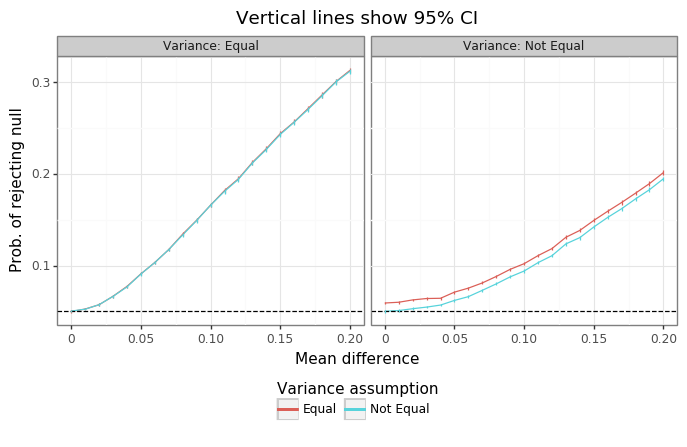

<ggplot: (8786008044325)>

In [2]:
# Parameters of simulations
nsim = 100000
alpha = 0.05
nlow, nhigh = 25, 75
n1, n2 = np.random.randint(nlow, nhigh+1, nsim), np.random.randint(nlow, nhigh+1, nsim)
se1, se2 = np.exp(np.random.randn(nsim)), np.exp(np.random.randn(nsim))
mu_seq = np.arange(0,0.21,0.01)
tt_seq, method_seq = np.repeat(['eq','neq'],2), np.tile(['neq','eq'],2)
holder = []
np.random.seed(1234)
for mu in mu_seq:
    # Generate random data
    x1 = mu + se1*np.random.randn(nhigh, nsim)
    x2a = se1 * np.random.randn(nhigh, nsim)
    x2b = se2 * np.random.randn(nhigh, nsim)
    idx = np.tile(np.arange(nhigh),[nsim,1]).T
    # Find which rows to set to missing
    idx1, idx2 = idx < rvec(n1), idx < rvec(n2)
    x1, x2a, x2b = np.where(idx1, x1, np.nan), np.where(idx2, x2a, np.nan), np.where(idx2, x2b, np.nan)
    mu_hat1, mu_hat2a, mu_hat2b  = np.nanmean(x1, 0), np.nanmean(x2a, 0), np.nanmean(x2b, 0)
    se_hat1, se_hat2a, se_hat2b = np.nanstd(x1, 0, ddof=1), np.nanstd(x2a, 0, ddof=1), np.nanstd(x2b, 0, ddof=1)
    # Calculate statistics and p-values
    tstat_neq_a, pval_neq_a = tdist_2dist(mu_hat1, mu_hat2a, se_hat1, se_hat2a, n1, n2, False)
    tstat_eq_a, pval_eq_a = tdist_2dist(mu_hat1, mu_hat2a,  se_hat1, se_hat2a, n1, n2, True)
    tstat_neq_b, pval_neq_b = tdist_2dist(mu_hat1, mu_hat2b, se_hat1, se_hat2b, n1, n2, False)
    tstat_eq_b, pval_eq_b = tdist_2dist(mu_hat1, mu_hat2b, se_hat1, se_hat2b, n1, n2, True)
    # Find hypothesis rejection probability
    power_neq_a, power_eq_a = np.mean(pval_neq_a < alpha), np.mean(pval_eq_a < alpha)
    power_neq_b, power_eq_b = np.mean(pval_neq_b < alpha), np.mean(pval_eq_b < alpha)
    power_seq = np.array([power_neq_a, power_eq_a, power_neq_b, power_eq_b])
    holder.append(pd.DataFrame({'mu':mu,'tt':tt_seq,'method':method_seq, 'power':power_seq}))
# Power comparison
di_method = {'eq':'Equal','neq':'Not Equal'}
res_power = pd.concat(holder).assign(nsim=nsim)
res_power[['tt','method']] = res_power[['tt','method']].apply(lambda x: x.map(di_method))
res_power = res_power.rename(columns={'tt':'Variance'}).assign(nreject=lambda x: (x.power*x.nsim).astype(int))
res_power = pd.concat([res_power.drop(columns=['nsim','nreject']),
            pd.concat(prop_CI(count=res_power.nreject,nobs=nsim,method='beta'),1)],1)
res_power.rename(columns={0:'lb',1:'ub'}, inplace=True)

plotnine.options.figure_size = (8, 3.5)
gg_power_ttest = (ggplot(res_power,aes(x='mu',y='power',color='method')) +
                  theme_bw()  + geom_line() +
                  geom_hline(yintercept=0.05,linetype='--') +
                  scale_color_discrete(name='Variance assumption') +
                  geom_linerange(aes(ymin='lb',ymax='ub')) +
                  ggtitle('Vertical lines show 95% CI') +
                  labs(y='Prob. of rejecting null',x='Mean difference') +
                  facet_wrap('~Variance',labeller=label_both) +
                  theme(legend_position=(0.5,-0.1),legend_direction='horizontal'))
gg_power_ttest

Figure 1 above shows that the `tdist_2dist` function is working as expected. When the variances of $x$ and $y$ are equivalent, there is no difference in performance between approaches. When the mean difference is zero, the probability of rejecting the null is exactly equivalent to the level of the test (5%). However, when the variances differ, using the degrees of freedom calculation assuming they are equal leads to an inflated type-I error rate. Whereas using the adjustment from [Welch's t-test](https://en.wikipedia.org/wiki/Welch%27s_t-test) gets to the right nominal level.

## (2) Checking power calculations

After checking that function's test-statistic has the right nominal coverage on simulated data, I find is useful to check whether the power of the test can be predicted for different values of the alternative hypothesis. For some test statistics, this is not possible to do analytically, since the distribution of the test statistic under the alternative may not be known. However, for the student-t distribution, a difference in true means amounts to a [noncentral t-distribution](https://en.wikipedia.org/wiki/Noncentral_t-distribution).

$$
\begin{align*}
T &= \frac{Z + c}{\sqrt{V/\nu}} \\ 
T &\sim \text{nct}(\nu,c) \\
Z&\sim N(0,1), \hspace{3mm} V\sim \chi^2(\nu), \hspace{3mm} \mu \neq 0
\end{align*}
$$

The statistic $d$ from \eqref{eq:dstat} can be modified to match the noncentral t-distribution:

$$
\begin{align*}
d + \underbrace{\frac{\mu_x - \mu_y}{\sqrt{\sigma^2_x/n + \sigma^2_y/m}}}_{c}.
\end{align*}
$$

The power simulations below will fix $n=25$, $m=75$, and unit variances when $\sigma_x=\sigma_y$ and $\sigma_x=1$ and $\sigma_y=2$ in the heteroskedastic case.

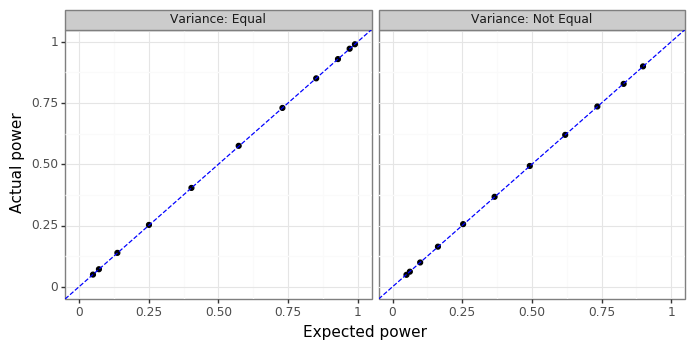

<ggplot: (8786007901169)>

In [3]:
n1, n2 = 25, 75
se1 = 1
se2a, se2b = se1, se1 + 1
var1, var2a, var2b = se1**2, se2a**2, se2b**2
# ddof under different assumptions
nu_a = n1 + n2 - 2
nu_b = (var1/n1 + var2b/n2)**2 / ( (var1/n1)**2/(n1-1) + (var2b/n2)**2/(n2-1) )
mu_seq = np.round(np.arange(0, 1.1, 0.1),2)

# Pre-calculate power
crit_ub_a, crit_lb_a = stats.t(df=nu_a).ppf(1-alpha/2), stats.t(df=nu_a).ppf(alpha/2)
crit_ub_b, crit_lb_b = stats.t(df=nu_b).ppf(1-alpha/2), stats.t(df=nu_b).ppf(alpha/2)
lam_a = np.array([mu/np.sqrt(var1*(1/n1 + 1/n2)) for mu in mu_seq])
lam_b = np.array([mu/np.sqrt((var1/n1 + var2b/n2)) for mu in mu_seq])
dist_alt_a, dist_alt_b = stats.nct(df=nu_a, nc=lam_a), stats.nct(df=nu_b, nc=lam_b)
power_a = (1-dist_alt_a.cdf(crit_ub_a)) + dist_alt_a.cdf(crit_lb_a)
power_b = (1-dist_alt_b.cdf(crit_ub_b)) + dist_alt_b.cdf(crit_lb_b)
dat_theory = pd.concat([pd.DataFrame({'mu':mu_seq,'theory':power_a,'method':'eq'}),
                        pd.DataFrame({'mu':mu_seq,'theory':power_b,'method':'neq'})])

# Run simulations to confirm
np.random.seed(1234)
holder = []
for mu in mu_seq:
    x1 = mu + se1 * np.random.randn(n1, nsim)
    x2a = se2a * np.random.randn(n2, nsim)
    x2b = se2b * np.random.randn(n2, nsim)
    mu_hat1, mu_hat2a, mu_hat2b  = x1.mean(0), x2a.mean(0), x2b.mean(0)
    se_hat1, se_hat2a, se_hat2b = x1.std(0,ddof=1), x2a.std(0, ddof=1), x2b.std(0, ddof=1)
    stat_a, pval_a = tdist_2dist(mu_hat1, mu_hat2a, se_hat1, se_hat2a, n1, n2, var_eq=True)
    stat_b, pval_b = tdist_2dist(mu_hat1, mu_hat2b, se_hat1, se_hat2b, n1, n2, var_eq=False)
    reject_a, reject_b = np.mean(pval_a < 0.05), np.mean(pval_b < 0.05)
    holder.append(pd.DataFrame({'mu': mu,'method':['eq','neq'], 'power': [reject_a, reject_b]}))
res_theory = pd.concat(holder).merge(dat_theory).sort_values(['method','mu']).reset_index(None, True)
res_theory = res_theory.assign(nreject=lambda x: (x.power*nsim).astype(int))
res_theory = pd.concat([res_theory.drop(columns='nreject'),
                        pd.concat(prop_CI(count=res_theory.nreject,nobs=nsim,method='beta'),1)],1)
res_theory.rename(columns={0:'lb',1:'ub','method':'Variance'}, inplace=True)
res_theory = res_theory.assign(Variance=lambda x: x.Variance.map(di_method))

plotnine.options.figure_size = (8, 3.5)
gg_power_theory = (ggplot(res_theory,aes(x='theory',y='power')) +
                   theme_bw() + geom_point() +
                   geom_linerange(aes(ymin='lb',ymax='ub')) +
                   facet_wrap('~Variance', labeller=label_both) +
                   theme(legend_position=(0.5, -0.1), legend_direction='horizontal') +
                   labs(x='Expected power',y='Actual power') +
                   scale_y_continuous(limits=[0,1]) + scale_x_continuous(limits=[0,1]) +
                   geom_abline(slope=1,intercept=0,color='blue',linetype='--'))
gg_power_theory

Figure 2 shows that the power calculations line up exactly with the analytical expectations for both equal and unequal variances. Having thoroughly validated the type-I and type-II errors of this function we can now move onto testing whether the means from multiple normal distributions are equal. 

## (3) F-test for equality of means

Suppose there are $K$ normal data vectors: $x_1=(x_{1,1},\dots,x_{1,n_1})$ to $x_k=(x_{k,1},\dots,x_{1,n_k})$, and we want to test the null hypothesis of $\mu_1 = \mu_2 = \dots = \mu_K$ against an alternative hypothesis that there is at least 1 inequality in the means, where $x_{k,i} \sim N(\mu_k,\sigma^2_k)$. As before, the variances of each vector may or may not be equal. When the variances are equal, the sum of squared differences between the total mean and any one group mean will be chi-square. Similarly, the sum of the sample variances will also have a chi-square distribution. Hence, the F-test for equality of means is the ratio of the variation "between" versus "within" the groups,

$$
\begin{align*}
R &= \frac{\frac{1}{K-1}\sum_{k=1}^K n_k (\bar x_k - \bar x)^2 }{\frac{1}{N-K}\sum_{k=1}^K (n_k - 1)\hat\sigma^2_k}, \\
R &\sim F(K-1, N-K) \hspace{3mm} \text{ if } \sigma^2_k = \sigma^2 \hspace{3mm} \forall k \in \{1,\dots,K\}
\end{align*}
$$

Where $N = \sum_k n_k$. To account for heteroskedasticity in the data (i.e. non-equal variances), both the test and degrees of freedom need to be modified using an [approach](https://doi.org/10.2307/2332579) Welch proposed in 1951.

$$
\begin{align*}
R_W &= \frac{\frac{1}{K-1}\sum_{k=1}^K w_k (\bar x_k - \bar x_w)^2 }{1 + \frac{2}{3}((K-2)\nu)}, \\
w_k &= n_k / \hat\sigma^2_k \\
\bar x_w &= \frac{\sum_{k=1}^K w_k \bar x_k}{\sum_{k=1}^K w_k}\\
\nu &= \frac{3\cdot \sum_{k=1}^K \Bigg[ \frac{1}{n_k - 1} \Big( 1 - \frac{w_k}{\sum_{k=1}^K w_k} \Big)^2 \Bigg]^2}{K^2-1} \\
R_W &\sim F(K-1, 1/\nu) \hspace{3mm} \text{ if } \sigma^2_k \neq \sigma^2_{-k} \hspace{3mm} \text{for at least one }k
\end{align*}
$$

The `fdist_anova` function below carries out an F-test for the equality of means using only the empirical means, standard deviations, and sample sizes for either variance assumption. In `R` this would be equivalent to using `aov` for equal variances or `oneway.test` for unequal variances. In `python`, it will replicate the `scipy.stats.f_oneway` function (for equal variances). I am unaware of a `python` function that does a Welch-adjustment (if you know please message me and I will provide an update with this information). As before, because the function only relies on the moments of the data, it can be fully vectorized to handle matrices of means, variances, and sample sizes. 

The simulation below assesses how well the two F-test approaches (homoskedasticity vs heteroskedasticity) do when the ground truth variances are either all equal or vary. To vary the signal in the data, I generate the $K$ different means from $(-\mu,\dots,0,\dots,\mu)$, where $\mu$ is referred to as "mean dispersion" in the subsequent figures.

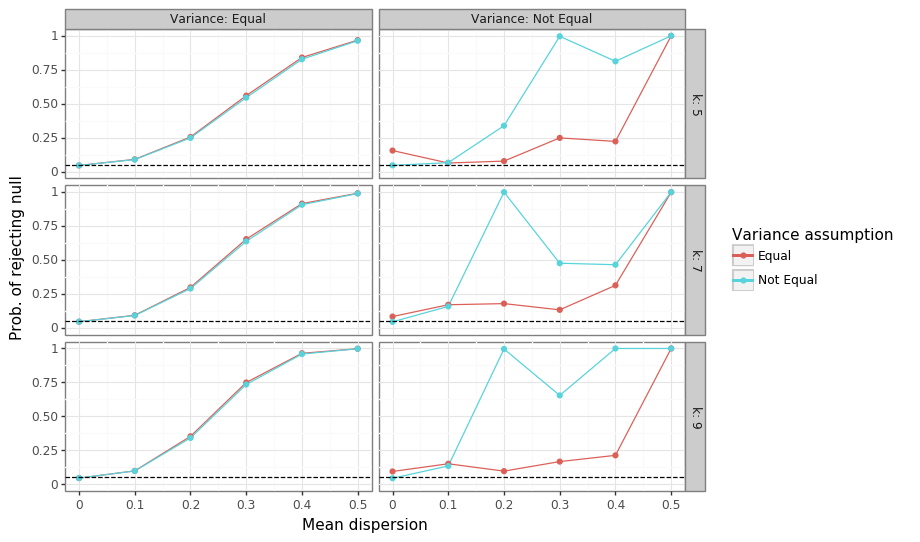

<ggplot: (8786012259973)>

In [4]:
def fdist_anova(mus, ses, ns, var_eq=False):
    lshape = len(mus.shape)
    assert lshape <= 2
    assert mus.shape == ses.shape
    if len(ns.shape) == 1:
        ns = cvec(ns.copy())
    else:
        assert ns.shape == mus.shape
    if lshape == 1:
        mus = cvec(mus.copy())
        ses = cvec(ses.copy())
    vars = ses ** 2  # variance
    n, k = ns.sum(0), len(ns)  # Total samples and groups
    df1, df2 = (k - 1), (n - k)
    if var_eq:  # classical anova
        xbar = np.atleast_2d(np.sum(mus * ns, 0) / n)
        vb = np.sum(ns*(xbar - mus)**2,0) / df1  # numerator is variance between
        vw = np.sum((vars * (ns - 1)), 0) / df2  # den is variance within
        fstat = vb / vw
        pval = stats.f(dfn=df1,dfd=df2).sf(fstat)
    else:
        w = ns / vars
        xbar = np.sum(w * mus, 0) / np.sum(w,0)
        num = np.sum(w * (xbar - mus) ** 2,0) / df1
        v = 3*np.sum((1-w/w.sum(0))**2 / (ns-1),0) / (k**2 - 1)
        den = 1 + 2*((k-2)*v)/3
        fstat = num / den
        pval = stats.f(dfn=df1, dfd=1/v).sf(fstat)
    return fstat, pval

nlow, niter = 25, 5
k_seq = [5, 7, 9]
disp_seq = np.round(np.arange(0, 0.51, 0.1),2)
dgp_seq = np.repeat(['eq', 'neq'], 2)
method_seq = np.tile(['eq', 'neq'], 2)

holder = []
np.random.seed(1)
for k in k_seq:
    n_seq = np.arange(nlow, nlow+k * niter, niter)
    n_seq = np.tile(n_seq, [nsim, 1]).T
    nhigh = np.max(n_seq)
    dim_3d = [1, 1, k]
    for disp in disp_seq:
        mu_k = np.linspace(-disp, disp, num=k)
        se_k1 = np.repeat(1,k).reshape(dim_3d)
        se_k2 = np.exp(np.random.randn(k)).reshape(dim_3d)
        X1 = mu_k + se_k1 * np.random.randn(nhigh,nsim,k)
        X2 = mu_k + se_k2 * np.random.randn(nhigh, nsim, k)
        idx = np.tile(np.arange(nhigh),[k,nsim,1]).T <= np.atleast_3d(n_seq).T
        X1, X2 = np.where(idx, X1, np.nan), np.where(idx, X2, np.nan)
        # Calculate means and variance : (k x nsim)
        mu_X1, mu_X2 = np.nanmean(X1, 0).T, np.nanmean(X2, 0).T
        se_X1, se_X2 = np.nanstd(X1, 0, ddof=1).T, np.nanstd(X2, 0, ddof=1).T
        assert n_seq.shape == mu_X1.shape == se_X1.shape
        # Calculate significance
        fstat_eq1, pval_eq1 = fdist_anova(mus=mu_X1, ses=se_X1, ns=n_seq, var_eq=True)
        fstat_neq1, pval_neq1 = fdist_anova(mus=mu_X1, ses=se_X1, ns=n_seq, var_eq=False)
        fstat_eq2, pval_eq2 = fdist_anova(mus=mu_X2, ses=se_X2, ns=n_seq, var_eq=True)
        fstat_neq2, pval_neq2 = fdist_anova(mus=mu_X2, ses=se_X2, ns=n_seq, var_eq=False)
        reject_eq1, reject_neq1 = np.mean(pval_eq1 < alpha), np.mean(pval_neq1 < alpha)
        reject_eq2, reject_neq2 = np.mean(pval_eq2 < alpha), np.mean(pval_neq2 < alpha)
        reject_seq = [reject_eq1, reject_neq1, reject_eq2, reject_neq2]
        tmp = pd.DataFrame({'k':k,'disp':disp,'dgp':dgp_seq,'method':method_seq,'reject':reject_seq})
        # print(tmp)
        holder.append(tmp)
res_f = pd.concat(holder).reset_index(None,True)
res_f[['dgp','method']] = res_f[['dgp','method']].apply(lambda x: x.map(di_method),0)
res_f.rename(columns={'dgp':'Variance'}, inplace=True)

plotnine.options.figure_size = (8, 6)
gg_fdist = (ggplot(res_f, aes(x='disp',y='reject',color='method.astype(str)')) +
            theme_bw() + geom_line() + geom_point() +
            facet_grid('k~Variance',labeller=label_both) +
            labs(x='Mean dispersion',y='Prob. of rejecting null') +
            geom_hline(yintercept=0.05,linetype='--') +
            scale_y_continuous(limits=[0,1]) +
            scale_color_discrete(name='Variance assumption'))
gg_fdist

The simulations in Figure 3 show a similar finding to the that of t-test: when the ground truth variances are equal, there is almost no differences between the tests, and an expected 5% false positive rate occurs when the means are equal. However, for the unequal variance situation, the assumption of homoskedasticity leads to an inflated type-I error rate (as was the case for the t-test), but also lower power when the null is false (which was not the case for the t-test). Using the Welch adjustment is better in both cases. The one surprising finding is that the power of the test is not monotonically increasing in the heteroskedastic case. I am not completely sure why this is the case. One theory could be that since a higher mean dispersion leads to a higher variance of $\bar{x}_w$, the ratio of the degrees of freedom may be more stable for lower values of $\mu$, leading to a more consistent rejection rate.

## (4) Quick sanity checks

After confirming the frequentist properties of a test statistic, it is worthwhile checking the results of any custom function to similar functions from other libraries. The `tdist_2dist` function will be compared to it's `scipy` counterpart on the [Iris](https://en.wikipedia.org/wiki/Iris_flower_data_set) dataset.

In [5]:
from sklearn import datasets
ix, iy = datasets.load_iris(return_X_y=True)
v1, v2 = ix[:,0], ix[:,1]
k = 1
all_stats = [stats.ttest_ind(v1, v2, equal_var=True)[k],
             tdist_2dist(v1.mean(), v2.mean(), v1.std(ddof=1), v2.std(ddof=1), len(v1), len(v2), var_eq=True)[k],
             stats.ttest_ind(v1, v2, equal_var=False)[k],
             tdist_2dist(v1.mean(), v2.mean(), v1.std(ddof=1), v2.std(ddof=1), len(v1), len(v2), var_eq=False)[k]]
pd.DataFrame({'test':'t-test',
              'method':np.tile(['scipy','custom'],2),
              'pval':all_stats})

,test,method,pval
0,t-test,scipy,7.027919e-112
1,t-test,custom,7.027919e-112
2,t-test,scipy,1.459543e-96
3,t-test,custom,1.459543e-96


So far so good. Next, we'll use `rpy2` to get the results in `R` which supports equal and unequal variances with two different functions.

In [7]:
import rpy2.robjects as robjects

moments_x = pd.DataFrame({'x':ix[:,0],'y':iy}).groupby('y').x.describe()[['mean','std','count']]

all_stats = [np.array(robjects.r('summary(aov(Sepal.Length~Species,iris))[[1]][1, 5]'))[0],
             fdist_anova(moments_x['mean'], moments_x['std'], moments_x['count'], var_eq=True)[1][0],
             np.array(robjects.r('oneway.test(Sepal.Length~Species,iris)$p.value'))[0],
             fdist_anova(moments_x['mean'], moments_x['std'], moments_x['count'], var_eq=False)[1][0]]
pd.DataFrame({'test':'F-test',
              'method':np.tile(['R','custom'],2),
              'pval':all_stats})

,test,method,pval
0,F-test,R,1.669669e-31
1,F-test,custom,1.669669e-31
2,F-test,R,1.505059e-28
3,F-test,custom,1.505059e-28


Once again the results are identical to the benchmark functions.

## (5) Application to AUROC inference

The empirical AUROC has an asymptotically normal distribution. Consequently, the difference between two AUROCs will also have an asymptotically normal distribution. For small sample sizes, the [Hanley and McNeil](http://www.med.mcgill.ca/epidemiology/hanley/software/Hanley_McNeil_Radiology_82.pdf) adjustment to the AUROC standard error will obtain slightly better coverage. For a review of the notation and meaning of the AUROC, see a previous post [here](http://www.erikdrysdale.com/auc_CI).

$$
\begin{align*}
AUC &= \frac{1}{n_1 n_0} \sum_{i: y_i = 1} \sum_{j: y_j=0} I(s_i > s_j) \\
\sigma_{N} &= \sqrt{\frac{n_1 + n_0 + 1}{12\cdot n_1 n_0}} \\ 
\sigma_{HM} &= \sqrt{\frac{AUC\cdot (1-AUC) + q_1 + q_0}{n_1 n_0}} \\
q_1 &= (n_1 - 1)\cdot ( AUC / (2-AUC) - AUC^2) \\
q_0&= (n_0- 1)\cdot ( AUC^2 / (1+AUC) - AUC^2)
\end{align*}
$$

The standard error from the normal approximation ($\sigma_N$) is only a function of the positive ($n_1$) and negative ($n_0$) class sample sizes whereas the Hanley and McNeil adjustment ($\sigma_{HM}$) uses the empirical AUROC as well. The previous t- and F-tests relied on the fact that the sample mean had a variance that $O(1/n)$ so that $\bar x \sim N(\mu, \sigma^2/n)$. As can be seen from either formula, the sample variance for the AUROC can not be nearly re-written as a function of the sample size. We can still appeal to the t-test, the only difference being that the sample size is built into the variance estimate:

$$
\begin{align*}
\frac{AUC_A - AUC_B}{\sqrt{\sigma^2_{HM_A} + \sigma^2_{HM_B}}} &\sim N(0,1) \hspace{3mm} \text{ if $H_0$ is true} 
\end{align*}
$$

In the simulation below, scores will come from one of two distributions. The negative class will have 200 samples drawn from a standard normal ($n_0$). The positive class scores will have 100 samples ($n_1$) drawn from either a standard normal (for the null distribution) and a normal with a mean at or above zero. The difference in AUROCs between these two distributions will be evaluated. Since the null distribution will have an (average) AUROC of 50%, the difference in these distribution will be above zero when the mean from the alternative is greater than zero.

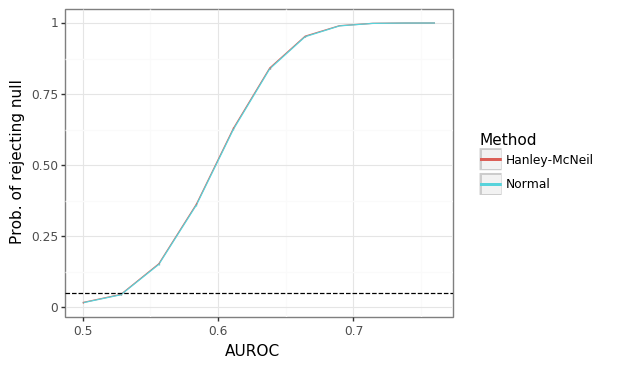

<ggplot: (8785929525461)>

In [23]:
n1, n0 = 100, 200
n = n1 + n0
n1n0 = n1 * n0
mu_seq = np.round(np.arange(0, 1.01, 0.1),2)

def se_auroc_hanley(auroc, n1, n0):
    q1 = (n1 - 1) * ((auroc / (2 - auroc)) - auroc ** 2)
    q0 = (n0 - 1) * ((2 * auroc ** 2) / (1 + auroc) - auroc ** 2)
    se_auroc = np.sqrt((auroc * (1 - auroc) + q1 + q0) / (n1 * n0))
    return se_auroc

def se_auroc_normal(n1, n0):
    return np.sqrt( (n1 + n0 + 1) / (12 * n1 * n0) )

np.random.seed(1)
holder = []
for mu in mu_seq:
    x1_null, x0 = np.random.randn(n1, nsim), np.random.randn(n0, nsim)
    x1 = mu + np.random.randn(n1, nsim)
    x, x_null = np.concatenate((x1, x0)), np.concatenate((x1_null, x0))
    auc = (np.sum(stats.rankdata(x, axis=0)[:n1],0) - n1*(n1+1)/2) / n1n0
    auc_null = (np.sum(stats.rankdata(x_null, axis=0)[:n1], 0) - n1 * (n1 + 1) / 2) / n1n0
    se_HM, se_null_HM = se_auroc_hanley(auc, n1, n0), se_auroc_hanley(auc_null, n1, n0)
    se_N = se_auroc_normal(n1, n0)
    # Do pairwise t-test
    dauc = auc - auc_null
    t_score_HM = dauc / np.sqrt(se_HM**2 + se_null_HM**2)
    t_score_N = dauc / np.sqrt(2 * se_N**2)
    dist_null = stats.t(df=2*n - 2)
    pval_HM = 2 * np.minimum(dist_null.sf(t_score_HM), dist_null.cdf(t_score_HM))
    pval_N = 2 * np.minimum(dist_null.sf(t_score_N), dist_null.cdf(t_score_N))
    reject_HM, reject_N = np.mean(pval_HM < alpha), np.mean(pval_N < alpha)
    tmp = pd.DataFrame({'method':['HM','N'],'mu':mu, 'reject':[reject_HM, reject_N]})
    holder.append(tmp)
# Merge and analyse
res_auc = pd.concat(holder).reset_index(None, True)
res_auc = res_auc.assign(auc=lambda x: stats.norm.cdf(x.mu/np.sqrt(2)),
                         nreject=lambda x: (x.reject*nsim).astype(int))
res_auc = pd.concat([res_auc.drop(columns='nreject'),
            pd.concat(prop_CI(count=res_auc.nreject,nobs=nsim,method='beta'),1)],1)
res_auc.rename(columns={0:'lb',1:'ub'},inplace=True)
    
# plot
plotnine.options.figure_size = (5, 4)
gg_auc = (ggplot(res_auc,aes(x='auc',y='reject',color='method')) + theme_bw() +
          geom_line() +
          labs(x='Alternative hypothesis AUROC',y='Prob. of rejecting null') +
          geom_hline(yintercept=0.05,linetype='--') +
          geom_linerange(aes(ymin='lb',ymax='ub')) + 
          scale_color_discrete(name='Method',labels=['Hanley-McNeil','Normal']))
gg_auc

Figure 4 shows that the standard errors from both methods yield almost identical results. Furthermore, the standard errors are conservative (too large), leading to an under-rejection of the null hypothesis when the null is true (i.e. the alternative hypothesis AUROC is 50%). The alternative hypothesis AUROC needs to reach around 53% before the rejection rate reaches the expected normal level. However, between 53%-70%, the power of the test approaches 100% for this sample size combination.